In [117]:
%matplotlib inline
from urllib.request import urlopen
from bs4 import BeautifulSoup
from bs4 import Comment
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
import scipy.stats as st
import re
from openpyxl import load_workbook
import seaborn as sns
import timeit
import sqlite3

# Load Data From CSV

In [118]:
df_train = pd.read_csv('train_data/n_seasons5_avgGames5_playoffsFalse_skipDays18_minmin25.csv')
df_train.drop(columns=['Unnamed: 0'], inplace=True)
df_train.head()

,player_id,team_id,opp_id,game_id,season_id,date,home,day_of_week,start_time,percent_season,...,team_ORtg,opp_diff_Pace,opp_diff_eFGp,opp_diff_TOVp,opp_diff_ORBp,opp_diff_FTvFGA,opp_diff_ORtg,target_PTS,target_TRB,target_AST
0,7,23,8,5208,5,2021-01-09,1,5,0.250000,0.131944,...,109.870,-8.224,0.0374,1.181,5.348,-0.0238,6.715,11,11,2
1,436,23,8,5208,5,2021-01-09,1,5,0.250000,0.131944,...,109.870,-8.224,0.0374,1.181,5.348,-0.0238,6.715,11,3,5
2,464,4,1,5209,5,2021-01-09,1,5,0.583333,0.131944,...,109.799,0.970,-0.0442,-0.292,-1.065,0.0300,-5.471,13,1,3
3,649,4,1,5209,5,2021-01-09,1,5,0.583333,0.131944,...,109.799,0.970,-0.0442,-0.292,-1.065,0.0300,-5.471,2,3,1
4,651,4,1,5209,5,2021-01-09,1,5,0.583333,0.131944,...,109.799,0.970,-0.0442,-0.292,-1.065,0.0300,-5.471,9,5,7


# Look for Strong Correlations

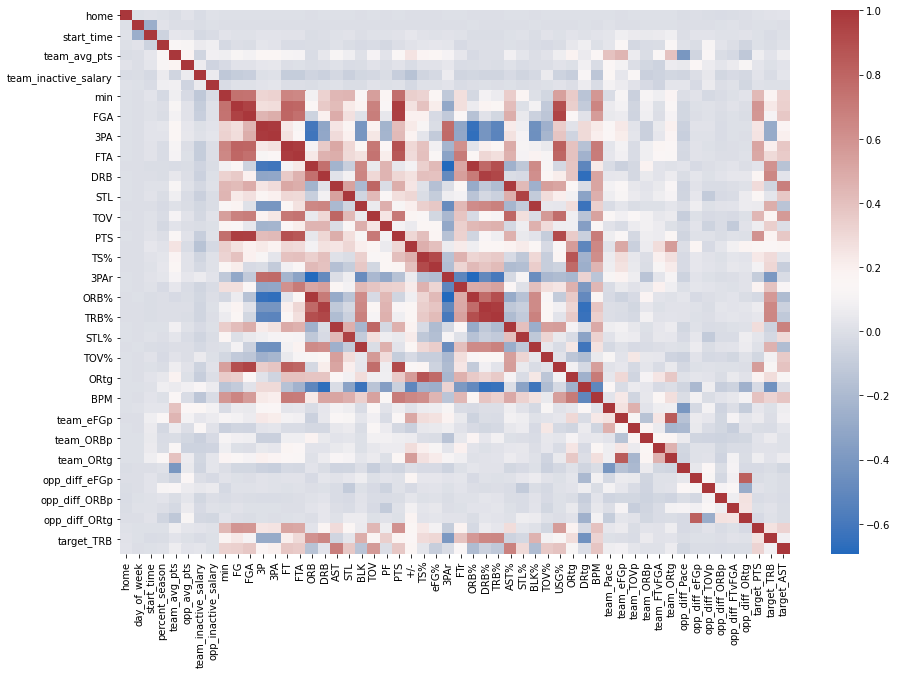

In [119]:
c = df_train.iloc[:, 6:].corr()
fig = plt.subplots(figsize=(15,10))
sns.heatmap(c,cmap=sns.color_palette("vlag", as_cmap=True))
mean_corr_before = np.mean(np.mean(c))

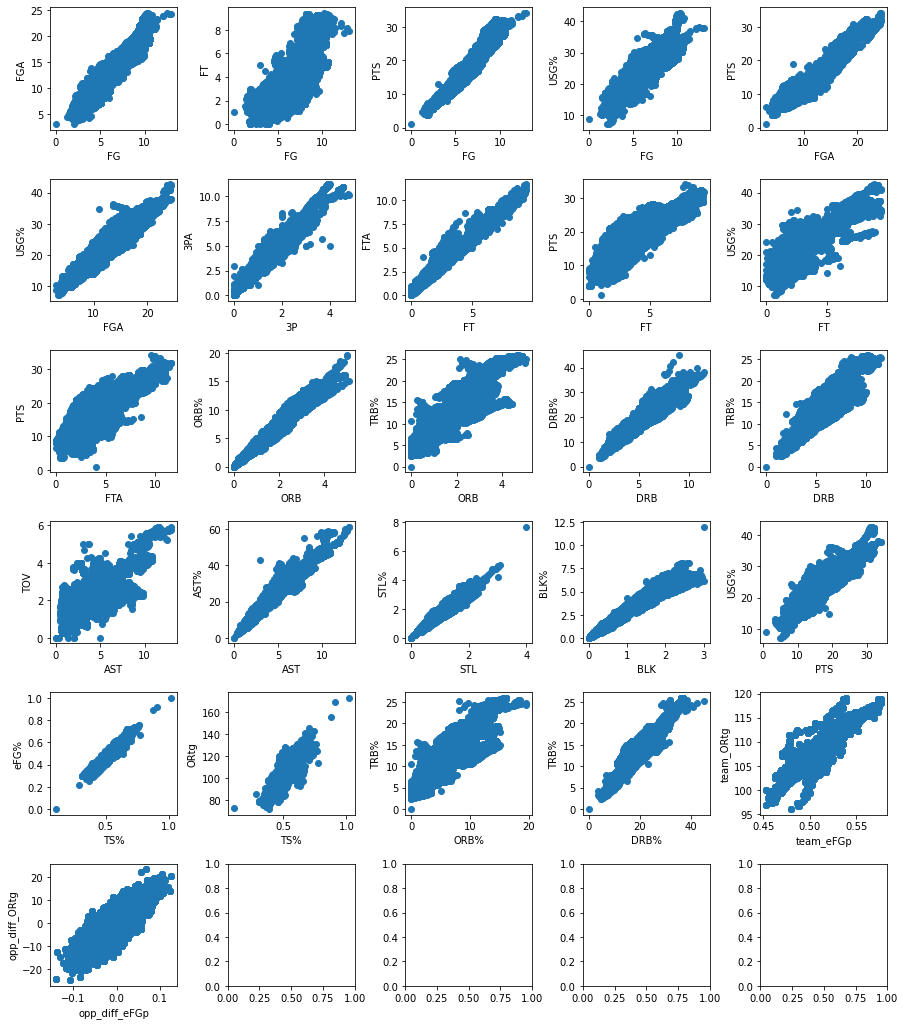

In [120]:
mask = c > 0.8

corr = []

for ind in c.index:
    for col in c.columns:
        if mask.loc[ind, col]:
            if col != ind:
                if (col, ind) not in corr:
                    corr.append((ind, col))                    

cols = 5
rows = int(np.ceil(len(corr) / cols))

fig, axs = plt.subplots(rows, cols, figsize=(15, 18))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

i = 0
for row in range(rows):
    for col in range(cols):
        axs[row, col].scatter(df_train[corr[i][0]], df_train[corr[i][1]])
        axs[row, col].set_xlabel(corr[i][0])
        axs[row, col].set_ylabel(corr[i][1])
        i+=1
        if i == len(corr):
            break
    

The above plots show features with Pearson R correlations greater than 0.8. It may be wise to remove features with high collinearity. Compare model accuracy with and without redundant features. Potential features to remove are:
1. FG (collinear with FGA, USG%, and PTS)
2. team_ORtg (collinear with team_avg_pts, team_eFGp)
3. ORB% (collinear with ORB)
4. DRB% (collinear with DRB, TRB%)
5. STL% (collinear with STL)
6. BLK% (collinear with BLK)
7. opp_diff_eFGp (collinear with off_diff_ORtg)
8. FT (collinear with FTA, PTS, USG%)
9. USG% (collinear with PTS, FG, FGA)
10. 3P (collinear with 3PA)
11. AST% (collinear with AST)
12. TS% (collienar with eFG%, ORtg)

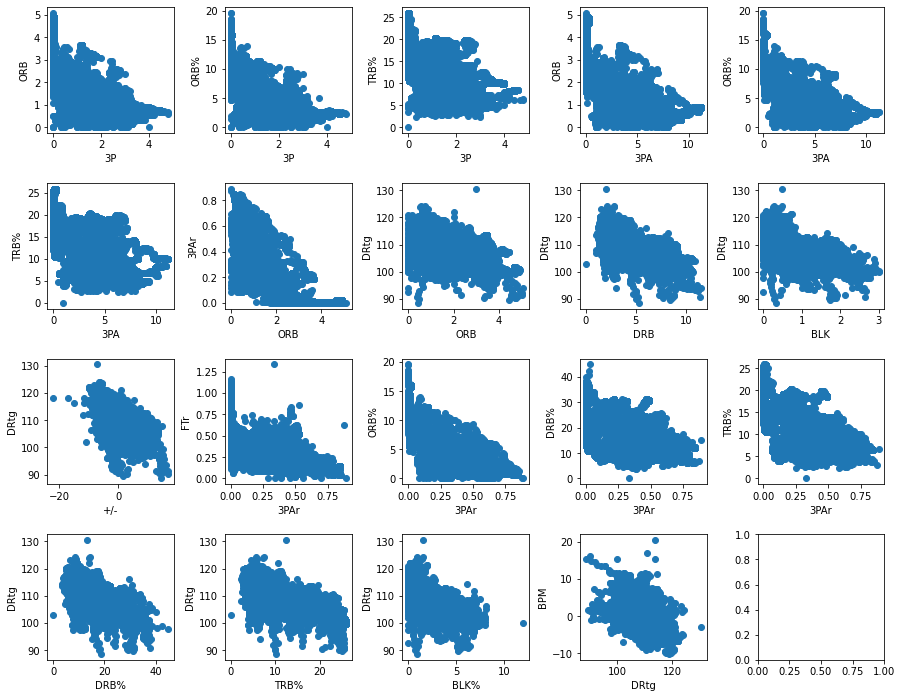

In [121]:
mask = c < -0.5

corr = []

for ind in c.index:
    for col in c.columns:
        if mask.loc[ind, col]:
            if col != ind:
                if (col, ind) not in corr:
                    corr.append((ind, col))
                    
cols = 5
rows = int(np.ceil(len(corr) / cols))

fig, axs = plt.subplots(rows, cols, figsize=(15,12))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

i = 0
for row in range(rows):
    for col in range(cols):
        axs[row, col].scatter(df_train[corr[i][0]], df_train[corr[i][1]])
        axs[row, col].set_xlabel(corr[i][0])
        axs[row, col].set_ylabel(corr[i][1])
        i+=1
        if i == len(corr):
            break

The negative correlations aren't particularly strong so there may not be a need to remove any features.

# Outliers

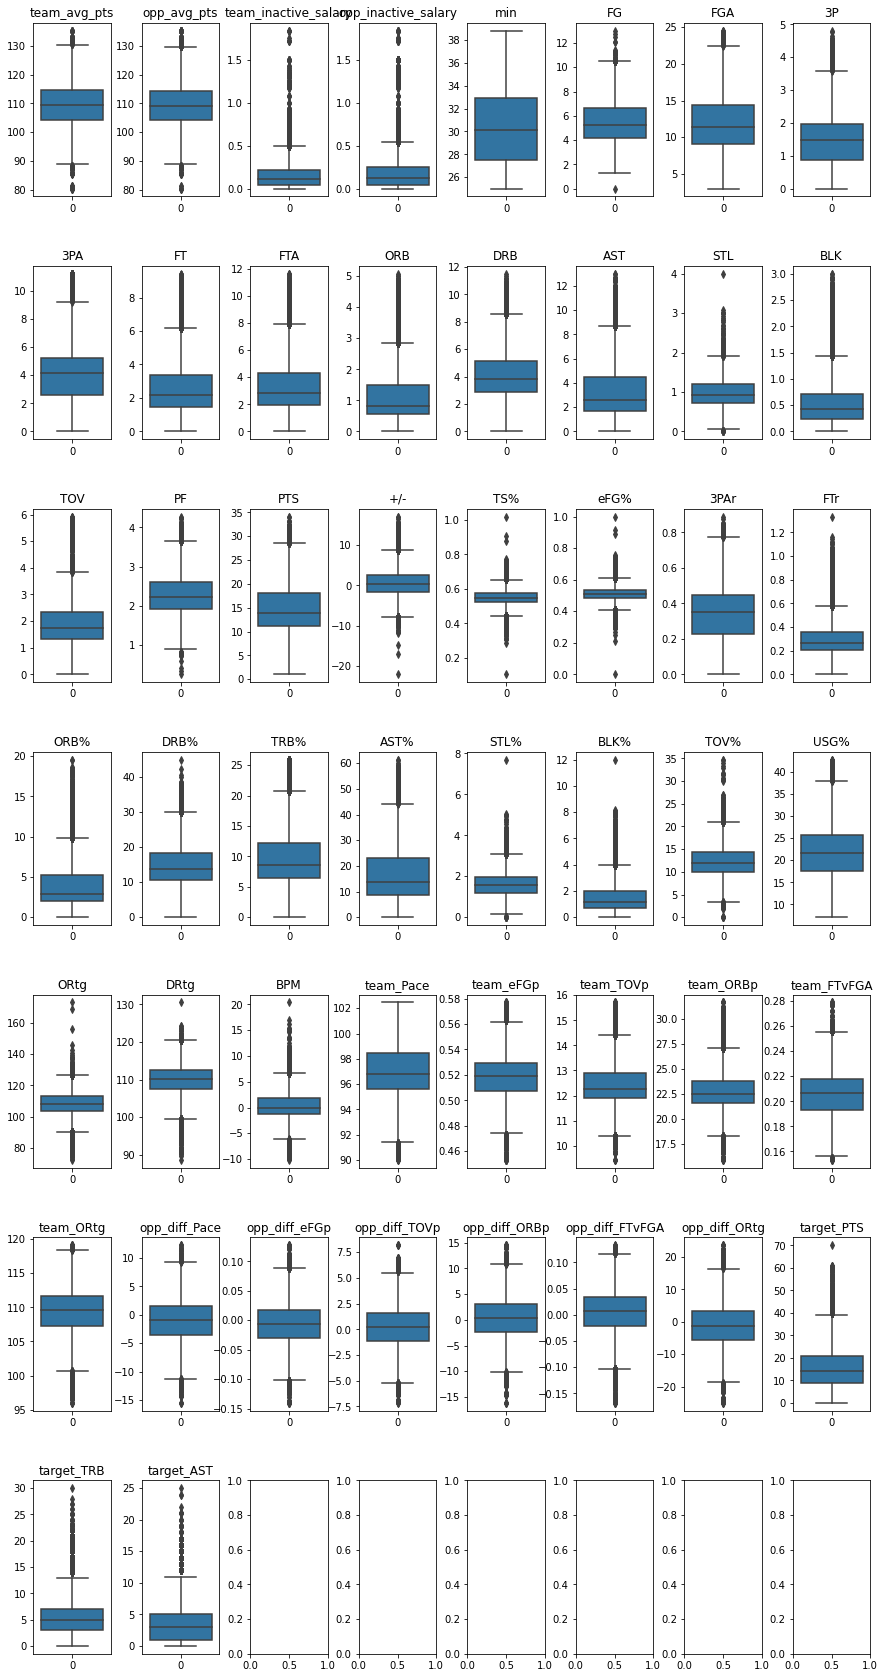

In [122]:
cols = 8
rows = int(np.ceil((len(df_train.columns) - 10) / cols))

fig, axs = plt.subplots(rows, cols, figsize=(15,30))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

i = 10
for row in range(rows):
    for col in range(cols):
        sns.boxplot(data=df_train[df_train.columns[i]], ax=axs[row, col])
        axs[row, col].set_title(df_train.columns[i])
        i+=1
        if i == len(df_train.columns):
            break

# look for non-normally distributed features
If a feature does not have an approximately normal distribution, it may need a transformation such as a log transform.

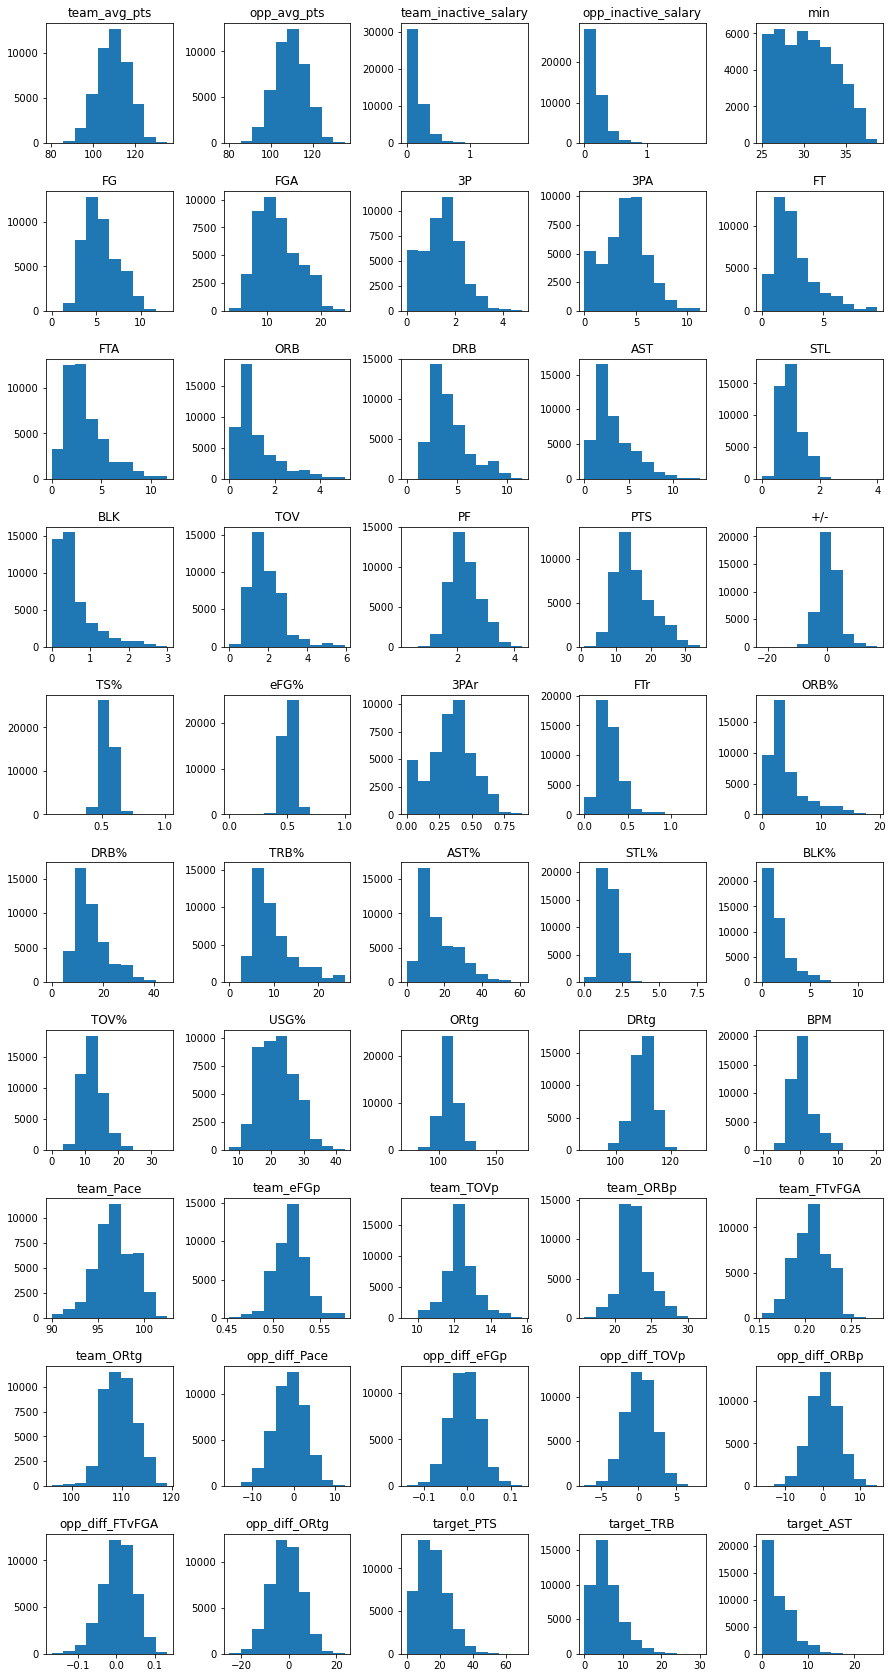

In [123]:
cols = 5
rows = int(np.ceil((len(df_train.columns) - 10) / cols))

fig, axs = plt.subplots(rows, cols, figsize=(15,30))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

i = 10
for row in range(rows):
    for col in range(cols):
        axs[row, col].hist(df_train[df_train.columns[i]])
        axs[row, col].set_title(df_train.columns[i])
        i+=1
        if i == len(df_train):
            break

In [124]:
skew_before = []
for col in df_train.columns[10:]:
    skew_before.append(st.skew(df_train[col]))

[-0.3876036748236552,
 -0.31022030515746024,
 -0.27576549630838293,
 -0.1662753259647301,
 -0.07757407561579974,
 -0.0589221691282574,
 -0.03351527687752984,
 -0.02996706279630432,
 -0.015878045552287518,
 -0.009965704759521882,
 0.0024059244479042127,
 0.020707293294177538,
 0.024266683145358858,
 0.06703123849720612,
 0.09282714488560313,
 0.10615927422325366,
 0.1581422740726038,
 0.2064636375169099,
 0.21738052545455125,
 0.3585575927632024,
 0.36456602039558633,
 0.4012699189450704,
 0.4080273221598525,
 0.49750994347461414,
 0.5116274667072689,
 0.5267494395773773,
 0.5311602897813993,
 0.6320233192051806,
 0.7075793701274163,
 0.7153375491981413,
 0.739259452932124,
 0.7534632086894447,
 0.8985148890142106,
 1.0872301683536851,
 1.1236409020585054,
 1.1293282581278845,
 1.207900640657298,
 1.2082035585799453,
 1.2361982761659187,
 1.2721556337971263,
 1.2979665541820116,
 1.3128793473069968,
 1.3629082209624812,
 1.5491438648683793,
 1.6278737252189415,
 1.6481527753869833,
 1.6

In [125]:
powers = [1, 1/2, 1/3, 1/4, 1/5]

power_for_cols = []
skew_for_cols = []

for col in df_train.columns[10:]:
    skew = []
    for power in powers:
        x = df_train[col].apply(lambda x: np.power(x, power))
        x = st.skew(x)
        if x < 5 and x > -5:
            skew.append(x)
        else:
            skew.append(999)
    ind = np.argmin(np.abs(skew))
    power = powers[ind]
    df_train[col] = df_train[col].apply(lambda x: np.power(x, power))
    power_for_cols.append(power)
    skew_for_cols.append(skew[ind])
    
skew_after = []
for col in df_train.columns[10:]:
    skew_after.append(st.skew(df_train[col]))

[-0.3876036748236552,
 -0.36898673755214023,
 -0.31022030515746024,
 -0.27576549630838293,
 -0.1662753259647301,
 -0.126786194019112,
 -0.10508487038356924,
 -0.08901250861263613,
 -0.0881618221762492,
 -0.07757407561579974,
 -0.0589221691282574,
 -0.04368542898350849,
 -0.04268262994267854,
 -0.040974154194617675,
 -0.03891380128132213,
 -0.03773273538901703,
 -0.03351527687752984,
 -0.02996706279630432,
 -0.025711227439781072,
 -0.023705432398190063,
 -0.023662377529279077,
 -0.015878045552287518,
 -0.013669363402444549,
 -0.009965704759521882,
 -0.0074881820381752185,
 -0.0018745103079329402,
 0.0024059244479042127,
 0.010984504615859376,
 0.020707293294177538,
 0.024266683145358858,
 0.04159204532491485,
 0.04564354438735224,
 0.04586691653575794,
 0.05689632335019835,
 0.06703123849720612,
 0.0833535585469653,
 0.09282714488560313,
 0.09486894217584933,
 0.10260277853455135,
 0.14034513712006497,
 0.15247516075126802,
 0.2064636375169099,
 0.23326084142454573,
 0.2464079093705131,

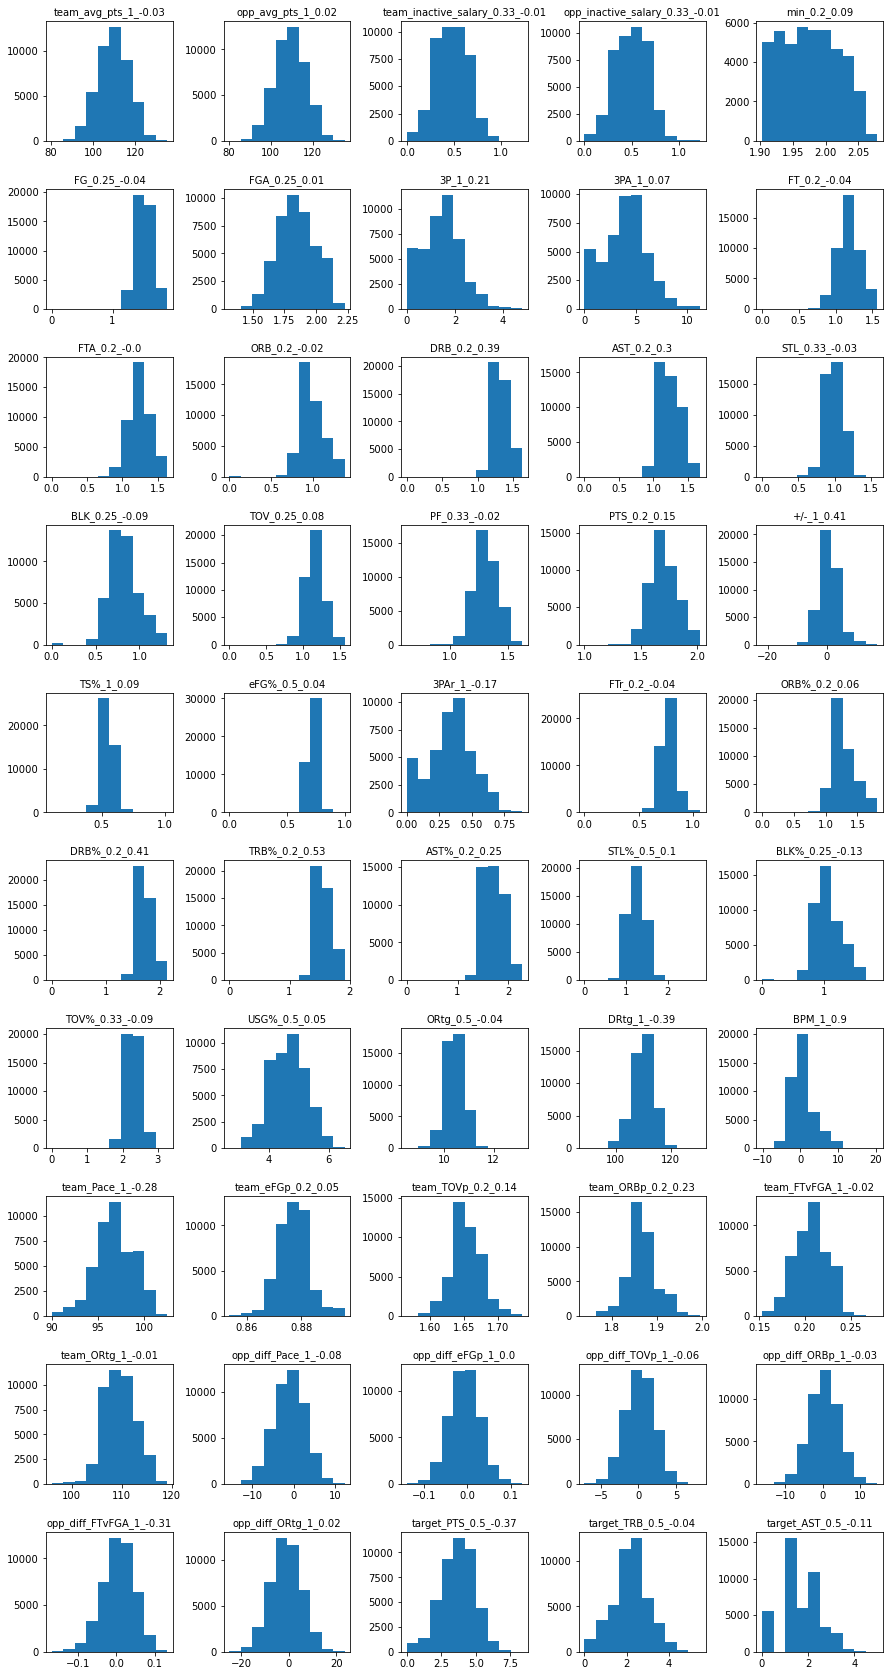

In [126]:
cols = 5
rows = int(np.ceil((len(df_train.columns) - 10) / cols))

fig, axs = plt.subplots(rows, cols, figsize=(15,30))
plt.subplots_adjust(wspace=0.4, hspace=0.4)    

i = 10
for row in range(rows):
    for col in range(cols):
        axs[row, col].hist(df_train[df_train.columns[i]])
        axs[row, col].set_title(df_train.columns[i] + '_' + 
                                str(round(power_for_cols[i-10],2)) + '_' + 
                                str(round(skew_for_cols[i-10],2)), fontsize=10)
        i+=1
        if i == len(df_train):
            break

In [127]:
skew_before_range = np.max(skew_before) - np.min(skew_before)
skew_after_range = np.max(skew_after) - np.min(skew_after)
skew_before_avg = np.mean(skew_before)
skew_after_avg = np.mean(skew_after)
print('Max skewness before transform: ', np.max(skew_before))
print('Max skewness after transform: ', np.max(skew_after))
print('Range of skewness before transform: ', skew_before_range)
print('Range of skewness after transform: ', skew_after_range)
print('Average skewness before transform: ', skew_before_avg)
print('Average skewness after transform: ', skew_after_avg)

Range of skewness before transform:  2.801771057349849
Range of skewness after transform:  1.2861185638378658
Average skewness before transform:  0.6544318363434837
Average skewness after transform:  0.043233495750903676


# Remove multicollinearity

In [128]:
remove_cols = ['FG', 'team_ORtg', 'ORB%', 'DRB%', 'STL%', 'BLK%', 'opp_diff_eFGp', 'FT',
               'USG%', '3P', 'AST%', 'TS%']
df_train.drop(columns=remove_cols, inplace=True)

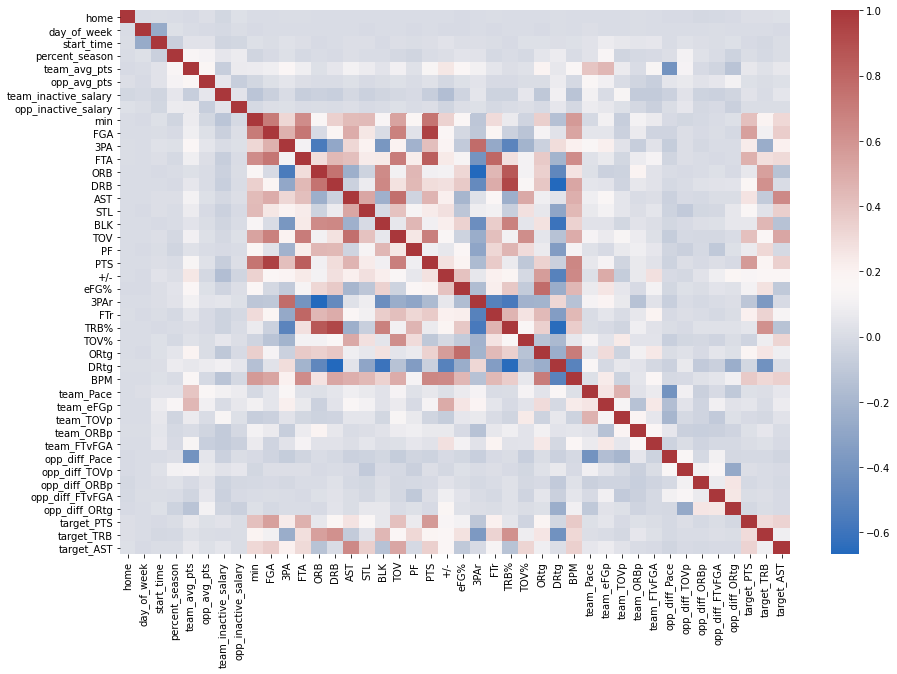

In [129]:
c = df_train.iloc[:, 6:].corr()
fig = plt.subplots(figsize=(15,10))
_ = sns.heatmap(c,cmap=sns.color_palette("vlag", as_cmap=True))
mean_corr_after = np.mean(np.mean(c))

In [130]:
print('mean correlation before removing columns with high collinearity: ', mean_corr_before)
print('mean correlation after removing columns with high collinearity: ', mean_corr_after)

mean correlation before removing columns with high collinearity:  0.10979980553265581
mean correlation after removing columns with high collinearity:  0.09222261056874796


# relationship of features and target variable

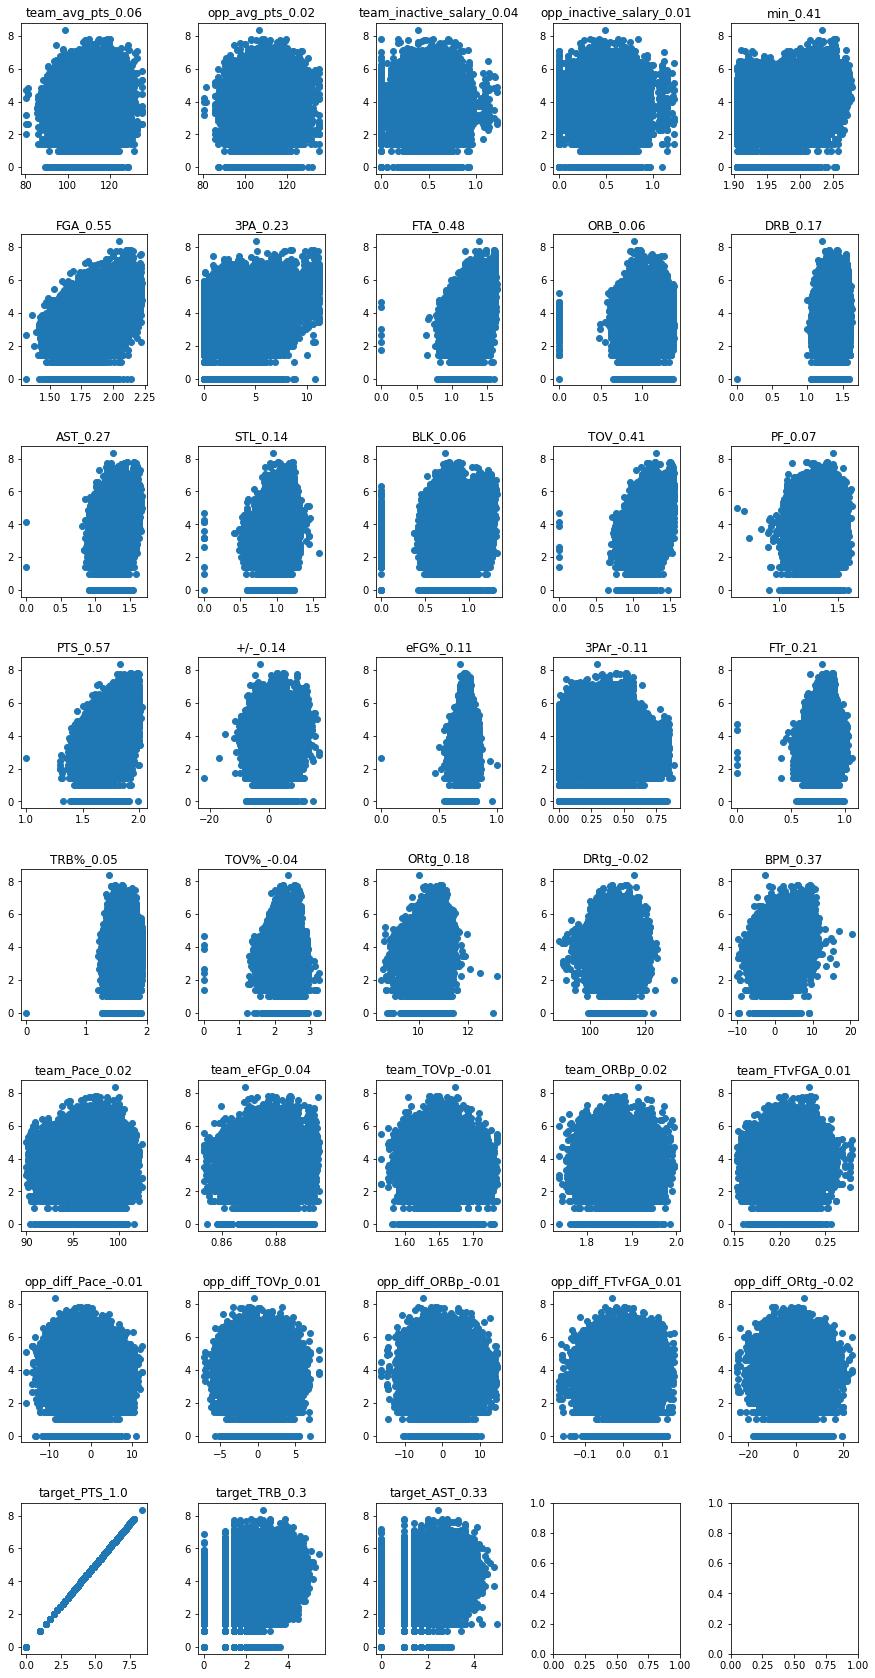

In [139]:
target = 'target_PTS'

cols = 5
rows = int(np.ceil((len(df_train.columns) - 10) / cols))

fig, axs = plt.subplots(rows, cols, figsize=(15,30))
plt.subplots_adjust(wspace=0.4, hspace=0.4)    

i = 10
for row in range(rows):
    for col in range(cols):
        corr = round(df_train[[df_train.columns[i], target]].corr().iloc[0,1], 2)
        axs[row, col].scatter(df_train[df_train.columns[i]], df_train[target])
        axs[row, col].set_title(df_train.columns[i] + '_' + str(corr))
        i+=1
        if i == len(df_train.columns):
            break

This exploratory analysis reveals the need to drop certain columns to reduce multicollinearity and to transform certain features to get a more approximately normal distribution.  This will be implemented as a function at the beginning of Jupyter Notebook prior to a deep learning model.